In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from lidar_diff_ray_casting import (
    diff_ray_casting_3d,
    get_voxel_centers_torch_tensor,
    voxel_distance_to_point,
    get_out_of_grid_dist_batch
)


Testing mode: same
Expected return range: [10.000001, 14.142138]
Gradient range: [-347.085999, 0.000000]

Testing mode: flat
Expected return range: [10.000001, 14.142138]
Gradient range: [-347.085968, 0.000000]

=== Expected Return Comparisons ===
same vs flat: max diff = 0.00000000

=== Gradient Comparisons ===
same vs flat: max diff = 0.00003052


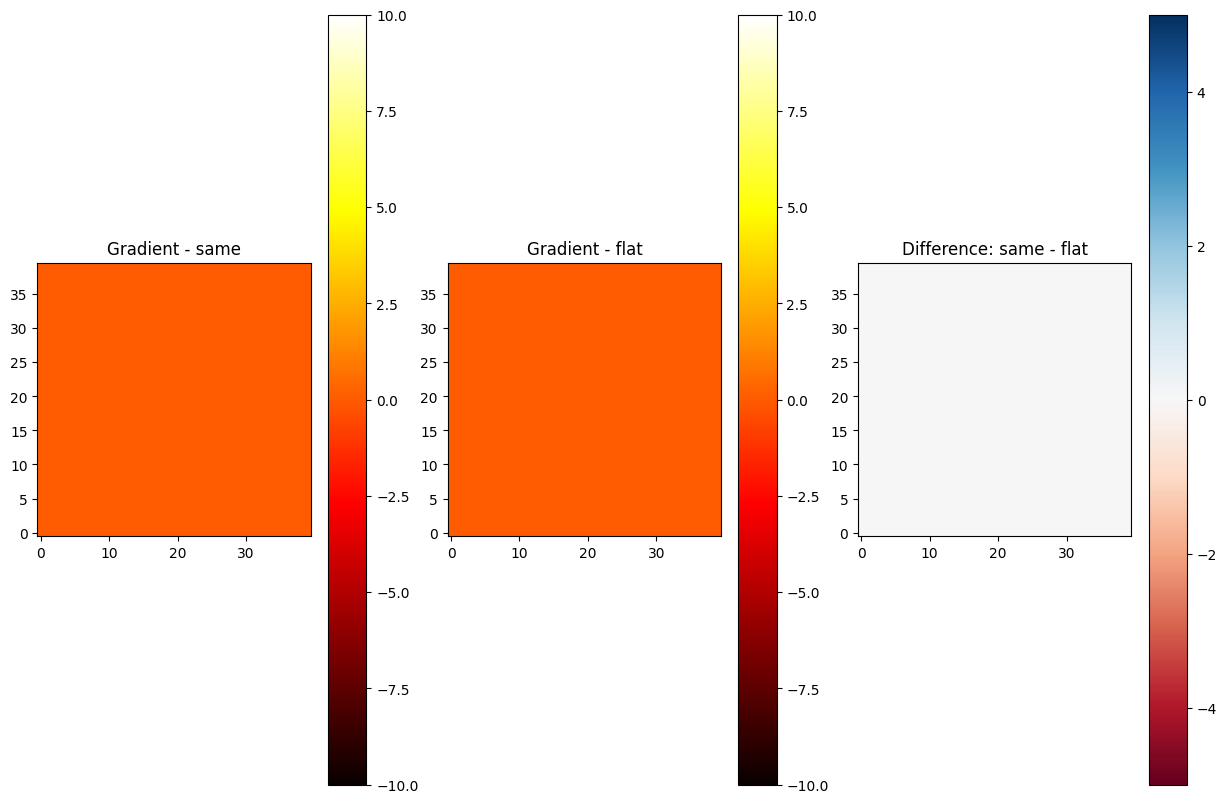

In [6]:
# Define a simple test case
sensor_origin = np.array([0.0, 0.0, 2.0], dtype=np.float32)
grid_min = np.array([-10.0, -10.0, 0.0], dtype=np.float32)
grid_max = np.array([10.0, 10.0, 5.0], dtype=np.float32)
voxel_size = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    
# Create simple occupancy grid
occupancy_shape = (
    int((grid_max[0] - grid_min[0]) / voxel_size[0]),
    int((grid_max[1] - grid_min[1]) / voxel_size[1]),
    int((grid_max[2] - grid_min[2]) / voxel_size[2]),
)
occupancy = torch.ones(occupancy_shape, dtype=torch.float32) * 1.0e-8
    
# Add some structure - ground plane
occupancy[:, :, 0] = 0.9
    
# Add a simple obstacle
occupancy[15:25, 15:25, 1:3] = 0.8
    
# Define simple ray directions (fewer rays for easier debugging)
n_ray = 32
azimuth = np.arange(0, 2 * np.pi, 2 * np.pi / n_ray)
elevation = np.array([0.0])  # Single elevation
azimuth_grid, elevation_grid = np.meshgrid(azimuth, elevation, indexing="ij")
azimuth_grid = azimuth_grid.reshape(-1)
elevation_grid = elevation_grid.reshape(-1)
ray_directions = np.stack([
    np.cos(azimuth_grid) * np.cos(elevation_grid),
    np.sin(azimuth_grid) * np.cos(elevation_grid),
    np.sin(elevation_grid),
], axis=-1)
    
# Compute distance and out-of-grid distances
voxel_centers = get_voxel_centers_torch_tensor(grid_min, grid_max, voxel_size)
dist_to_sensor = voxel_distance_to_point(
    voxel_centers, torch.tensor(sensor_origin, dtype=torch.float32)
)
out_of_grid_dists = get_out_of_grid_dist_batch(
    sensor_origin, ray_directions, grid_min, grid_max
)
out_of_grid_dists = torch.tensor(out_of_grid_dists, dtype=torch.float32)
    
# Test all three modes
modes = ["same", "flat"]
gradients = {}
expected_returns = {}
    
for mode in modes:
    print(f"\nTesting mode: {mode}")
        
    # Clone occupancy and enable gradients
    occ = occupancy.clone()
    occ.requires_grad_(True)
        
    # Forward pass
    exp_ret = diff_ray_casting_3d(
        sensor_origin=sensor_origin,
        ray_directions=ray_directions,
        grid_min=grid_min,
        grid_max=grid_max,
        voxel_size=voxel_size,
        occupancy=occ,
        vox_dist_to_sensor=dist_to_sensor.clone(),
        out_of_grid_dists=out_of_grid_dists.clone(),
        pad_mode=mode,
    )
        
    # Backward pass
    exp_ret.sum().backward()
        
    # Store results
    expected_returns[mode] = exp_ret.detach().cpu().numpy()
    gradients[mode] = occ.grad.detach().cpu().numpy()
        
    print(f"Expected return range: [{exp_ret.min():.6f}, {exp_ret.max():.6f}]")
    print(f"Gradient range: [{occ.grad.min():.6f}, {occ.grad.max():.6f}]")
    
# Compare expected returns
print("\n=== Expected Return Comparisons ===")
print(f"same vs flat: max diff = {np.max(np.abs(expected_returns['same'] - expected_returns['flat'])):.8f}")
    
# Compare gradients
print("\n=== Gradient Comparisons ===")
print(f"same vs flat: max diff = {np.max(np.abs(gradients['same'] - gradients['flat'])):.8f}")
    
# Plot gradient comparisons for layer z=1
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
z_layer = 1
    
# Plot gradients
for i, mode in enumerate(modes):
    im = axes[i].imshow(gradients[mode][:, :, z_layer], cmap='hot', vmin=-10, vmax=10)
    axes[i].set_title(f'Gradient - {mode}')
    axes[i].invert_yaxis()
    plt.colorbar(im, ax=axes[i])
    
# Plot gradient differences
diff_same_flat = gradients['same'] - gradients['flat']
    
im1 = axes[2].imshow(diff_same_flat[:, :, z_layer], cmap='RdBu', vmin=-5, vmax=5)
axes[2].set_title('Difference: same - flat')
axes[2].invert_yaxis()
plt.colorbar(im1, ax=axes[2])
plt.show()